In [1]:
# %load ../helpers/header.py
SUB_DIR = "Unsupervised"
# load ENV path to project from .profile 
import os, sys
PROJECT_ROOT_DIR=os.environ.get('ML_PATH')
sys.path.append(os.path.join(PROJECT_ROOT_DIR, "helpers")) # add helper modules to path

# MPL 
import MPL_header #load common MPL imports (from helpers)
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib widget 

# NP, constant seed, PD 
import numpy as np
np.random.seed(12345)
import pandas as pd

# Where to save the figures
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "fig", SUB_DIR)
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "fig")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# K-Means 

`from sklearn.cluster import KMeans`  
`k=5`  
`kmeans = KMeans(n_clusters=k) `  
`y_pred = kmeans.fit_predict(X)`

## and the `predicted` labels accessed via `y_pred` or `kmeans.labels_`, in case of 2D centroids `kmeans.cluster_centers_` (can then use Voronoi cells to blod the boundaries e.g. https://nbviewer.jupyter.org/gist/pv/8037100)
## predict new instances
`X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])`  
`kmeans.predict(X_new)`

## Soft clustering: score of belonging to clusters or distance from clusters (cf. hard clustering above), `kmeans.transform(X_new)`

# ! ways you can mitigate this risk by improving the centroid initialization (avoiding local minima), be default the ``kmeans.inertia_`` (MSD instance-centroid)
`good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])`  
`kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)`  

# Finding the optimal number of clusters

## ! Very rough: shoulder in invertia vs. #clusters.
## silhouette score `silhouette_score()`: +1=well inside, 0=close to boundart, -1=might be wrong cluster
## silhouette vs #clusters, and even better silhouette diagramm

# ! N.B. remember feature scaling for KMEANS, For ellipses - Gaussian mixture models.

# Using Clustering for Image Segmentation

In [2]:
from matplotlib.image import imread
image = imread(os.path.join(PROJECT_ROOT_DIR, "handson-ml2", "images","unsupervised_learning","ladybug.png"))
image.shape

(533, 800, 3)

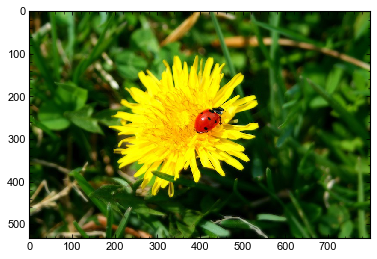

In [3]:
plt.imshow(image)

In [4]:
from sklearn.cluster import KMeans
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

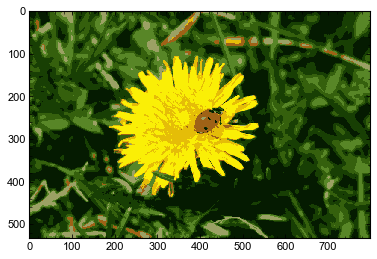

In [5]:
plt.imshow(segmented_img)

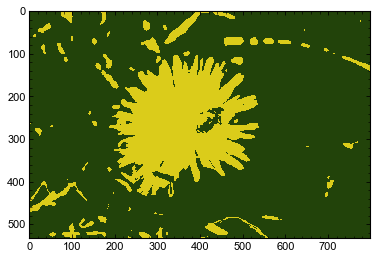

In [6]:
kmeans = KMeans(n_clusters=2).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)
plt.imshow(segmented_img)

# Using Clustering for Preprocessing

## ! without initial D-reducation (baseline)

In [7]:
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

In [9]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
print("Baseline:", log_reg.score(X_test, y_test))

Baseline: 0.9488888888888889


# with clustering

In [10]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=50)), # 10 digits, but have varitions (e.g. 0 and more curvy 0 - so 5 per digit...)
        ("log_reg", LogisticRegression()),
    ])
pipeline.fit(X_train, y_train)
print("Baseline:", pipeline.score(X_test, y_test))

Baseline: 0.9622222222222222


## the best value of k is simply the one that results in the best classifica‐ tion performance during cross-validation

In [30]:
from sklearn.model_selection import GridSearchCV
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=1, n_jobs=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 294 out of 294 | elapsed:  2.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=50, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=None, tol=0.0001,
                                               verbose=0)),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                    

In [31]:
grid_clf.best_params_

{'kmeans__n_clusters': 54}

In [32]:
grid_clf.score(X_test, y_test)

0.9466666666666667

# Using Clustering for Semi-Supervised Learning

In [11]:
n_labeled = 50
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

0.8222222222222222

In [12]:
print(f"score for {n_labeled} labelled instances {log_reg.score(X_test, y_test):.3}")

score for 50 labelled instances 0.822


In [13]:
k=50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Saving figure representative_images_diagram


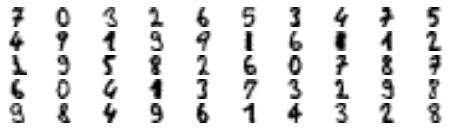

In [19]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [25]:
y_representative_digits = np.array([
    7, 0, 3, 2, 6, 5, 3, 4, 7, 5,
    4, 9, 1, 9, 9, 1, 6, 8, 1, 2,
    1, 9, 5, 8, 2, 6, 0, 7, 8, 7,
    6, 0, 4, 1, 3, 7, 3, 2, 9, 8,
    9, 8, 4, 9, 6, 1, 4, 3, 2, 8])

In [30]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
print(f"score for {n_labeled} labelled representative instances of clusters {log_reg.score(X_test, y_test):.3}")

score for 50 labelled representative instances of clusters 0.878


## Label propagation

In [53]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32) 
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [54]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)
print(f"score for {n_labeled} label propagation to {y_train_propagated.shape} instances {log_reg.score(X_test, y_test):.3}")

score for 50 label propagation to (1347,) instances 0.913


# Let’s see what happens if we only propagate the labels to the 20% of the instances that are closest to the centroids:

In [80]:
percentile_closest = 20
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [81]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [82]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
print(f"score for {n_labeled} label propagation to {percentile_closest}% closest instances in a cluster {log_reg.score(X_test, y_test):.3}")

score for 50 label propagation to 20% closest instances in a cluster 0.891


In [83]:
print("the quality of propagation", np.mean(y_train_partially_propagated == y_train[partially_propagated]))

the quality of propagation 0.9623287671232876


# Active Learning: expert labels instances with largest uncertainty

# DBSCAN:  density-based clustering non-parametric algorithm

In [2]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.05)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

## -1 == anomalous clusters

In [4]:
dbscan.labels_[0:5]

array([7, 2, 0, 1, 2])

In [5]:
len(dbscan.core_sample_indices_)

789

In [6]:
len(dbscan.labels_)

1000

In [9]:
dbscan.components_

array([[-0.11272809,  0.97610825],
       [-0.9413427 ,  0.14925256],
       [ 1.91612707,  0.20648769],
       ...,
       [-0.90808988,  0.47576185],
       [-0.25391408,  0.98497398],
       [-0.96891929,  0.15074489]])

In [10]:
# can use KNN to predict (DBSCAN has only fit_predict)
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
print(knn.predict(X_new), knn.predict_proba(X_new))

[1 3 9 2] [[0.   0.94 0.   0.06 0.   0.   0.   0.   0.   0.   0.  ]
 [0.04 0.   0.   0.96 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.08 0.   0.24 0.28 0.   0.   0.   0.4  0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


# Gaussian Mixtures: probabilistic model that assumes that the instances were generated from a mixture of several Gaussian distributions whose parameters are unknown

In [16]:
from sklearn.datasets import make_blobs
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [17]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [18]:
gm.weights_

array([0.20965228, 0.39028152, 0.4000662 ])

In [19]:
gm.means_

array([[ 3.39909717,  1.05933727],
       [ 0.05135313,  0.07524095],
       [-1.40763984,  1.42710194]])

In [20]:
 gm.covariances_

array([[[ 1.14807234, -0.03270354],
        [-0.03270354,  0.95496237]],

       [[ 0.68809572,  0.79608475],
        [ 0.79608475,  1.21234145]],

       [[ 0.63478101,  0.72969804],
        [ 0.72969804,  1.1609872 ]]])

In [21]:
gm.converged_

True

In [22]:
 gm.predict(X) # "hard-clustering"

array([1, 1, 2, ..., 0, 0, 0])

In [23]:
gm.predict_proba(X) # soft-clustering"

array([[2.32389467e-02, 9.76760376e-01, 6.77397850e-07],
       [1.64685609e-02, 9.82856078e-01, 6.75361303e-04],
       [2.01535333e-06, 7.49319577e-05, 9.99923053e-01],
       ...,
       [9.99999571e-01, 4.28788333e-07, 2.13946075e-26],
       [1.00000000e+00, 5.12459171e-16, 1.46454409e-41],
       [1.00000000e+00, 2.27626238e-15, 8.02006365e-41]])

## GM is a generative model - can ask to make a new sample!

In [26]:
X_new, y_new = gm.sample(6)
y_new

array([0, 1, 1, 2, 2, 2])

## PDF: exp(scores) [prob = integral(PDF)]

In [27]:
 gm.score_samples(X)

array([-2.60782346, -3.57106041, -3.33003479, ..., -3.51352783,
       -4.39802535, -3.80743859])

array([0.07369477, 0.02812601, 0.03579186, ..., 0.02979163, 0.01230161,
       0.02220498])

# Anomaly Detection using GMM

###  novelty detection: train on the clean dataset, and detect anomalies

## ! no silhouette/shoulder method for GMM (not reliable when the clusters are not spherical or have different sizes), so use  theoretical infor‐ mation criterion, such as the Bayesian information criterion (BIC) or the Akaike information criterion (AIC).

In [31]:
gm.bic(X)

8189.74345832983

In [33]:
gm.aic(X)

8102.518178214792

## Then we look for AIC and BIC vs. #clusters - shoulder!

## “probability” is used to describe how plausible a future outcome x is (knowing the parameter values θ),

## “likelihood” is used to describe how plausible a particular set of parameter values θ are, after the outcome x is known.

# Bayesian Gaussian Mixture Models: Set the number of clusters n_components to a value that you have good reason to believe is greater than the optimal number of clusters (this assumes some minimal knowledge about the problem at hand), and the algo‐ rithm will eliminate the unnecessary clusters automatically.

In [34]:
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=10, n_init=10)
bgm.fit(X)
np.round(bgm.weights_, 2) # only 3 clusters - perfect!

array([0.21, 0.4 , 0.39, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])